In [55]:
# Basic libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import seaborn as sn



#!pip3 install pyramid-arima
import pmdarima as pm

#Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

# SCIPY
from scipy.stats import boxcox

# SKLearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Iteration
from itertools import product
from tqdm import tqdm_notebook

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#Figure Sizes and Label font-sizes
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linewidth":0.8, "grid.alpha": 0.5})

In [56]:
# Load Data
data = pd.read_csv('data.csv')  # Ensure filename matches

data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Annual_Mean']]
data.set_index('Year', inplace=True)
df = data
df.head()

,Annual_Mean
Year,
1901,27.34
1902,27.16
1903,27.12
1904,27.09
1905,27.06


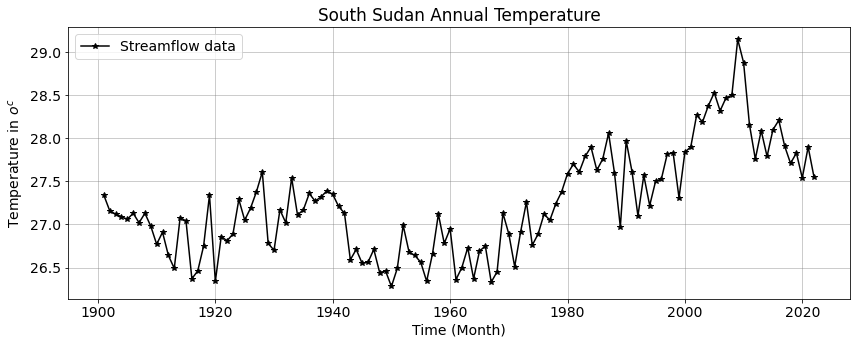

In [57]:
plt.rcParams.update({'figure.figsize': [14,5]})
plt.rcParams.update({'font.size': 14})
plt.plot(df.index, df['Annual_Mean'], 'b*-', label='Streamflow data', c='black', alpha=1)
plt.title('South Sudan Annual Temperature')
plt.xlabel('Time (Month)')
plt.ylabel('Temperature in $o^{c}$')
plt.grid(True)
plt.legend()
# plt.savefig('revisedImages/sobat_streamflow_volume_1915_144.png')
plt.show()

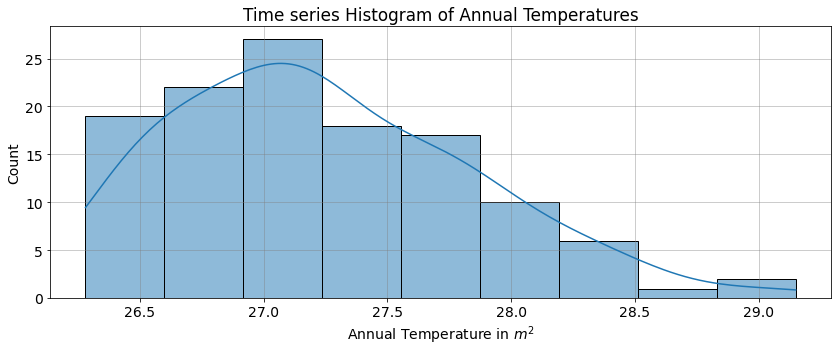

In [58]:
sns.histplot(df['Annual_Mean'], kde=True)
plt.title('Time series Histogram of Annual Temperatures')
plt.xlabel('Annual Temperature in $m^{2}$')
plt.grid(True)
# plt.savefig('revisedImages/sobat_histogram_of_streamflow.png')
plt.show()

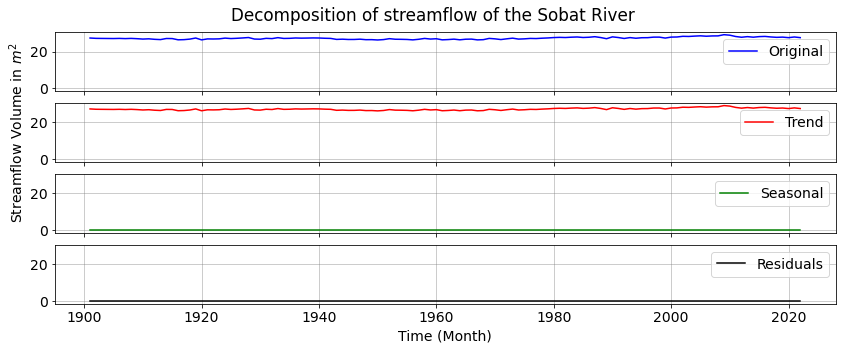

In [65]:
ts_decompose_add = seasonal_decompose(df['Annual_Mean'], model='additive', period=1,)  # Adjust period as needed
estimated_trend_add = ts_decompose_add.trend
estimated_seasonal_add = ts_decompose_add.seasonal
estimated_residual_add = ts_decompose_add.resid

fig, axes = plt.subplots(4, 1, sharex="all", sharey=True)
plt.rcParams.update({'figure.figsize': [14,5]})
plt.suptitle('Decomposition of streamflow of the Sobat River',x=0.5, y=0.95)
plt.xlabel('Time (Month)')



axes[0].plot(df['Annual_Mean'], label='Original', color='b')
axes[0].legend(loc='upper right');

axes[1].plot(estimated_trend_add, label='Trend', color='r')
axes[1].legend(loc='upper right');

axes[2].plot(estimated_seasonal_add, label='Seasonal', color='g')
axes[1].set_ylabel('Streamflow Volume in $m^{2}$')
axes[2].legend(loc='upper right');

axes[3].plot(estimated_residual_add, label='Residuals', color='black')
axes[3].legend(loc='upper right');
# plt.savefig('revisedImages/sobat_decompositions_of_streamflow.png')

In [66]:
ad_fuller_result = adfuller(df['Annual_Mean'])
print(f'Test Statistics: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Lags used: {ad_fuller_result[2]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (ad_fuller_result[1] < 0.05):
    print('The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing')
if (ad_fuller_result[1] > 0.05):        
    print('The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing')

kpss_result = kpss(df['Annual_Mean'])
print(f'Test Statistics: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Number of Lags used: {kpss_result[2]}')
for key, value in kpss_result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (kpss_result[1] > 0.05):
    print('The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)')
if (kpss_result[1] < 0.05):        
    print('The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)')

Test Statistics: -1.525602491821358
p-value: 0.5208102866684788
Lags used: 2
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057
The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing
Test Statistics: 1.0177462964290311
p-value: 0.01
Number of Lags used: 6
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)


In [68]:
# Apply differencing if needed

df['Annual_Mean'] = df['Annual_Mean'].diff().dropna()
print("Differencing was applied to make the series stationary.")
df.head()

Differencing was applied to make the series stationary.


,Annual_Mean
Year,
1901,NaN
1902,NaN
1903,0.14
1904,0.01
1905,0.00


In [73]:
dt = df.dropna()
ad_fuller_result = adfuller(dt['Annual_Mean'])
print(f'Test Statistics: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Lags used: {ad_fuller_result[2]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (ad_fuller_result[1] < 0.05):
    print('The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing')
if (ad_fuller_result[1] > 0.05):        
    print('The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing')

kpss_result = kpss(dt['Annual_Mean'])
print(f'Test Statistics: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Number of Lags used: {kpss_result[2]}')
for key, value in kpss_result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (kpss_result[1] > 0.05):
    print('The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)')
if (kpss_result[1] < 0.05):        
    print('The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)')

Test Statistics: -10.2578994791216
p-value: 4.312723072663224e-18
Lags used: 5
Critial Values:
   1%, -3.489057523907491
Critial Values:
   5%, -2.887246327182993
Critial Values:
   10%, -2.5804808802708528
The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing
Test Statistics: 0.10872414994767099
p-value: 0.1
Number of Lags used: 16
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)


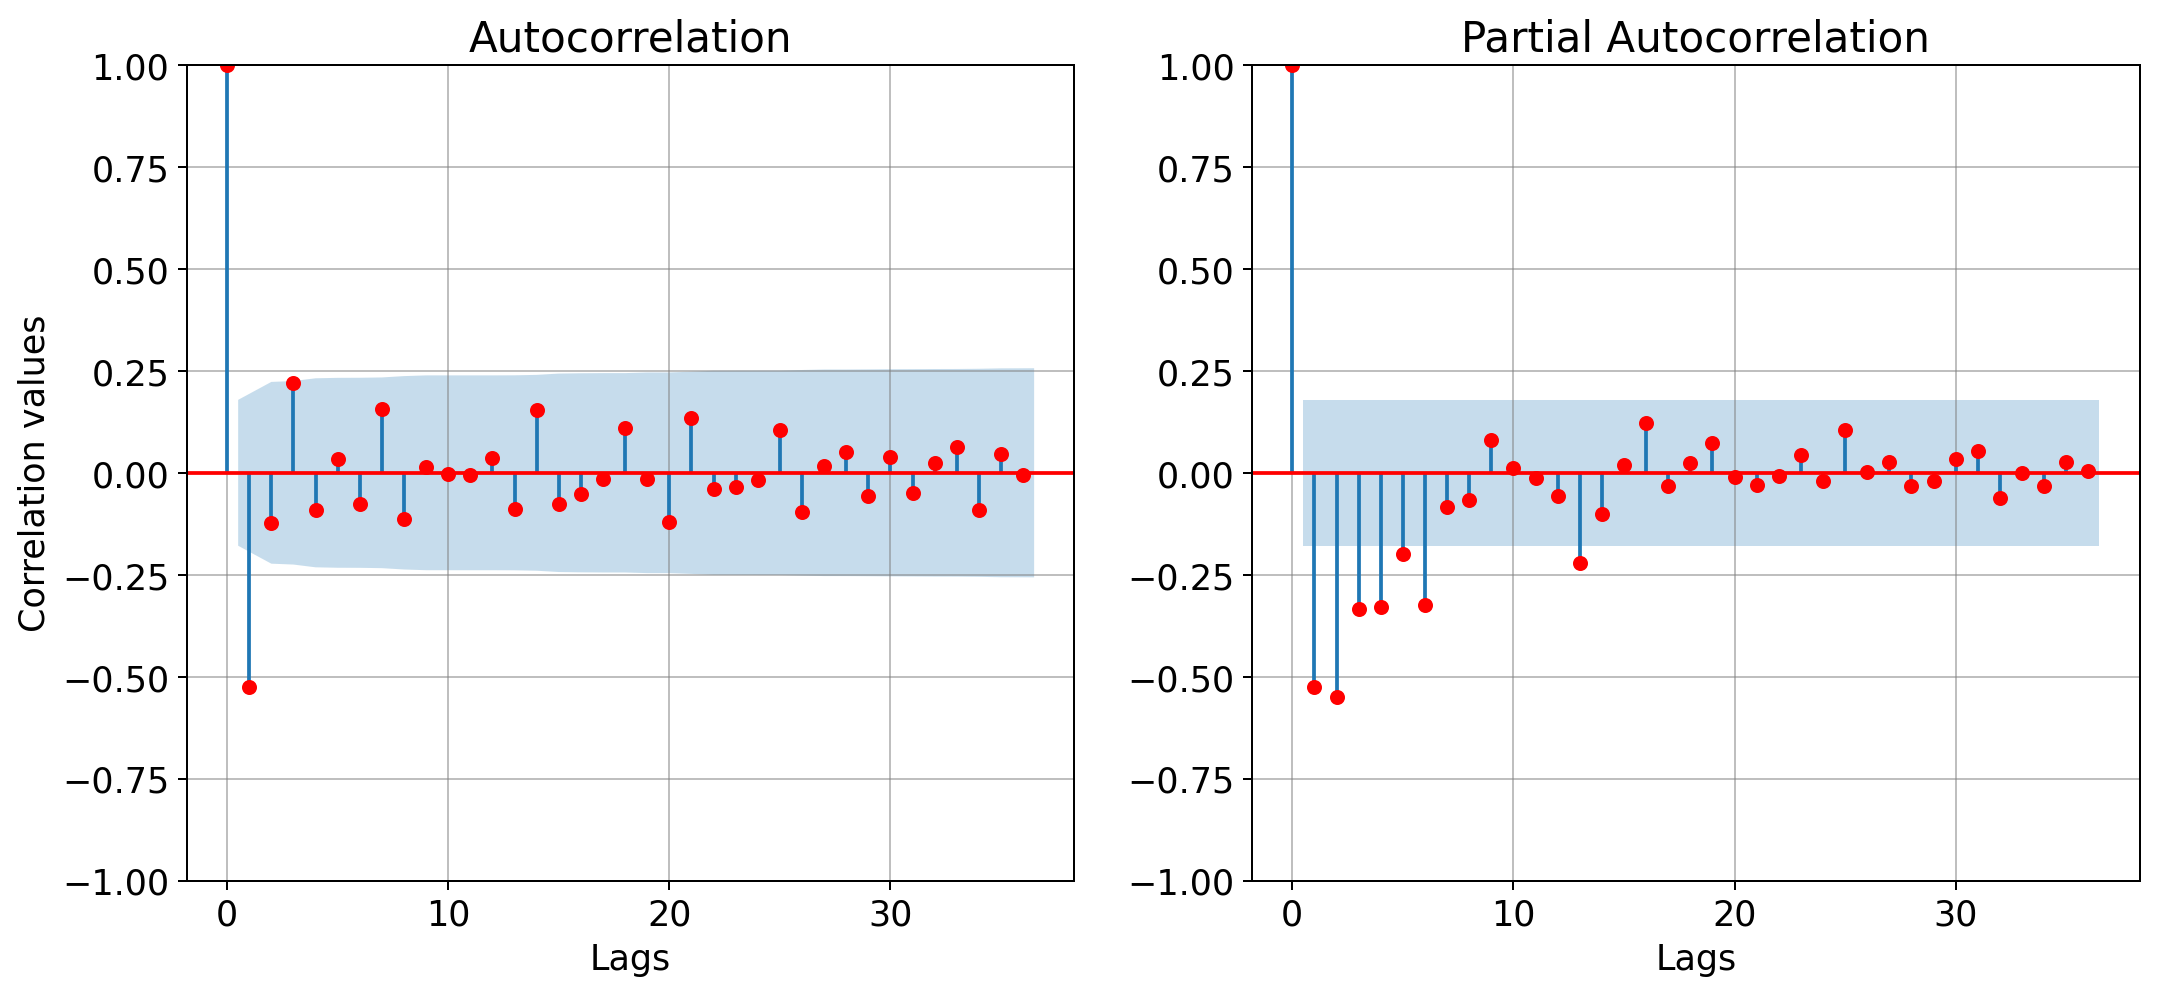

In [77]:
fig, (axis1, axis2) = plt.subplots(1,2, dpi=180)
plt.rcParams['figure.figsize'] = [10,6]
#plt.rcParams.update({'font.size': 24})
plot_acf(dt['Annual_Mean'], lags=36, color='red', ax=axis1)
plot_pacf(dt['Annual_Mean'], lags=36, color='red', ax=axis2, method='ywm')
axis1.set_xlabel('Lags')
axis2.set_xlabel('Lags')
axis1.set_ylabel('Correlation values')
# plt.savefig('revisedImages/sobat_acf_pacf_of_streamflow.png')
plt.show()

In [104]:
# Train-Test Split
split_index = int(len(df) * 0.95)
train, test = df.iloc[:split_index], df.iloc[split_index:]
test.head()

,Annual_Mean
Year,
2016,-0.20
2017,-0.41
2018,0.10
2019,0.32
2020,-0.41


In [105]:
# SARIMA Model using AutoARIMA
auto_arima_model_sarima = auto_arima(train.dropna(), seasonal=True, m=1, d=1, D=1, trace=True, suppress_warnings=True)
best_order_sarima = auto_arima_model_sarima.order
best_seasonal_order_sarima = auto_arima_model_sarima.seasonal_order

sarima_model = SARIMAX(train.dropna(), order=best_order_sarima, seasonal_order=best_seasonal_order_sarima)
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=82.022, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.405, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=259.912, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=311.407, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.544 seconds


In [109]:
# ARIMA Model using AutoARIMA
auto_arima_model = auto_arima(train.dropna(), seasonal=False, m=4, d=1, D=0, trace=True, suppress_warnings=True)
best_order = auto_arima_model.order

arima_model = ARIMA(train.dropna(), order=best_order)
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=82.022, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.405, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=259.912, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=311.407, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.165 seconds


In [107]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}')

evaluate(test['Annual_Mean'].iloc[-len(arima_pred):], arima_pred, 'ARIMA')
evaluate(test['Annual_Mean'].iloc[-len(sarima_pred):], sarima_pred, 'SARIMA')

ARIMA -> MAE: 0.3484, RMSE: 0.4224, R²: 0.0768
SARIMA -> MAE: 0.3484, RMSE: 0.4224, R²: 0.0768


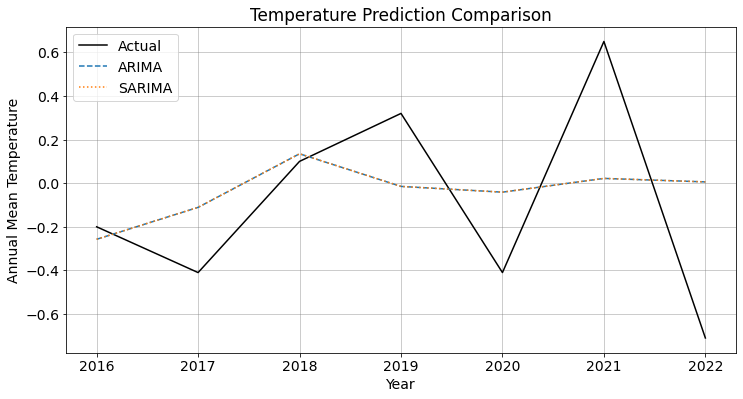

In [108]:
# Plot Results
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Annual_Mean'], label='Actual', color='black')
plt.plot(test.index[-len(arima_pred):], arima_pred, label='ARIMA', linestyle='dashed')
plt.plot(test.index[-len(sarima_pred):], sarima_pred, label='SARIMA', linestyle='dotted')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Annual Mean Temperature')
plt.title('Temperature Prediction Comparison')
plt.show()

In [112]:
# Seasonal - fit stepwise auto-ARIMA
data = pd.read_csv('data.csv')  # Ensure filename matches

data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Annual_Mean']]
data.set_index('Year', inplace=True)

smodel = pm.auto_arima(data['Annual_Mean'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, start_Q=0, max_Q=3,seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=135.596, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=210.000, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=114.214, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=210.456, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=142.005, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=108.048, Time=0.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=191.098, Time=0.24 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=104.739, Time=0.66 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=111.096, Time=0.34 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=96.174, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  122
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 -41.166
Date:                            Tue, 07 Jan 2025   AIC                             94.331
Time:                                    23:42:50   BIC                            110.534
Sample:                                         0   HQIC                           100.903
                                            - 122                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5460      0.098      5.549      0.000       0.353       0.739
ar.L2          0.0350      0.114      0.308      0.758      -0.188       0.258
ar.L3          0.3123      0.098      3.191      0.001       0.121       0.504
ar.S.L12      -0.6540      0.118     -5.561      0.000      -0.884      -0.423
ar.S.L24      -0.3004      0.108     -2.791      0.005      -0.511      -0.089
sigma2         0.1166      0.019      6.175      0.000       0.080       0.154
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.79   Prob(JB):                         0.33
Heteroskedasticity (H):               1.21   Skew:                            -0.31
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
# Step 1: Split data into training and testing sets
train_size = int(len(data) * 0.95)

# Use slicing to split data into training and testing sets
X_train, X_test = data.index[:train_size], data.index[train_size:]
y_train, y_test = data['Annual_Mean'][:train_size], data['Annual_Mean'][train_size:]

# Display the last two rows of X_test
print(X_test[2:])


Int64Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='Year')


In [125]:
smodel.fit(y_train)

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

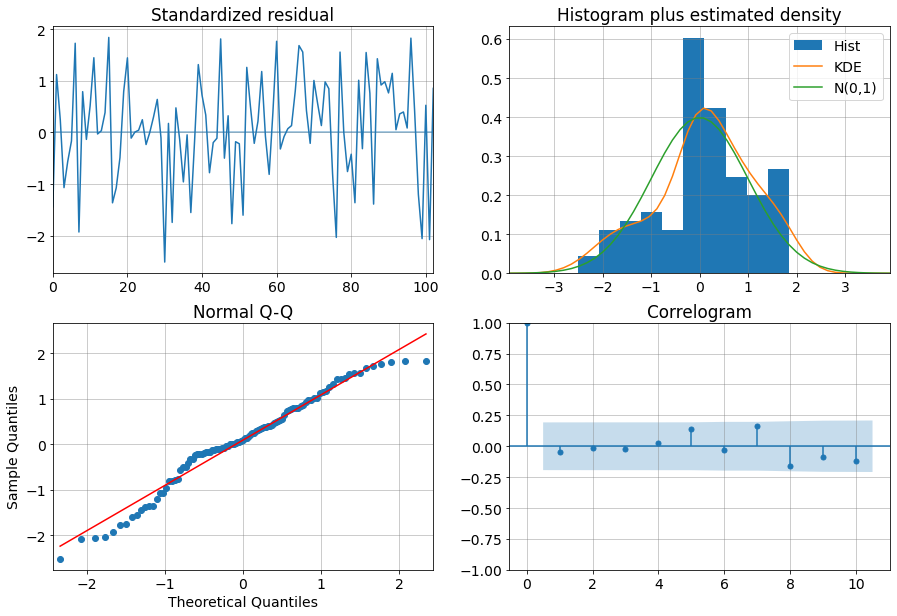

In [127]:
# Assuming you have a SARIMA model fitted and stored in 'sarima_model'
# Replace 'sarima_model' with your actual SARIMA model
smodel.plot_diagnostics(figsize=(15,10))
#plt.rcParams.update({'font.size': 16})

# Get the summary as a string
# summary_str = str(smodel.summary())

# Create an empty plot
# fig, ax = plt.subplots(figsize=(10, 6))

# Plot the text as an annotation on the empty plot
# ax.annotate(summary_str, xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=10)

# Remove axes for a cleaner image
# ax.axis('off')

# Save the plot as an image
# plt.savefig('hybridProphetSARIMAImages/Fig7.jpeg', bbox_inches='tight', dpi=300)
plt.show()

In [128]:
testing_data = y_test
sarima_predictions = smodel.predict(n_periods=5)
sarima_predictions = pd.DataFrame(sarima_predictions,index = X_test.index,columns=['Predictions'])
pd.concat([testing_data,sarima_predictions],axis=1)

sarima_predictions.head

AttributeError: 'Int64Index' object has no attribute 'index'

In [129]:
# Ensure testing_data is a DataFrame for proper alignment
testing_data = y_test.to_frame(name='Actual')

# Generate SARIMA predictions for the test set
sarima_predictions = smodel.predict(n_periods=len(y_test))

# Convert predictions to a DataFrame and align with X_test
sarima_predictions = pd.DataFrame(sarima_predictions, index=X_test, columns=['Predictions'])

# Concatenate actual and predicted values for comparison
results = pd.concat([testing_data, sarima_predictions], axis=1)

# Display the first few rows of the predictions
results.head()


,Actual,Predictions
Year,,
2016,28.21,NaN
2017,27.91,NaN
2018,27.71,NaN
2019,27.83,NaN
2020,27.54,NaN


In [138]:
# Load and preprocess data
data = pd.read_csv('data.csv')
data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']
data = data[['Year', 'Annual_Mean']].set_index('Year')

# Check for null values and drop them
data = data.dropna()


In [139]:
# Split data into training and testing sets
train_size = int(len(data) * 0.95)
X_train, X_test = data.index[:train_size], data.index[train_size:]
y_train, y_test = data['Annual_Mean'][:train_size], data['Annual_Mean'][train_size:]

# Ensure training data has no nulls
print(f"Null values in training data: {y_train.isnull().sum()}")

Null values in training data: 0


In [147]:
# SARIMA Model using AutoARIMA
auto_arima_model_sarima = auto_arima(y_train.dropna(), seasonal=True, m=1, d=1, D=1, trace=True, suppress_warnings=True)
best_order_sarima = auto_arima_model_sarima.order
best_seasonal_order_sarima = auto_arima_model_sarima.seasonal_order

sarima_model = SARIMAX(train.dropna(), order=best_order_sarima, seasonal_order=best_seasonal_order_sarima)
smodel = sarima_model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58.724, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.639, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.535, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.716, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.683, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57.035, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=61.035, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61.921, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=58.484, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=57.096, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59.405, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=59.498, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=55.380, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=59.429, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.258, Time=0.05 s

In [148]:
# Print model summary
print(smodel.summary())

                               SARIMAX Results                                
Dep. Variable:            Annual_Mean   No. Observations:                  115
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 -23.608
Date:                Wed, 08 Jan 2025   AIC                             55.216
Time:                        00:12:20   BIC                             66.160
Sample:                             0   HQIC                            59.658
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4481      0.088     -5.111      0.000      -0.620      -0.276
ma.L2         -0.2854      0.099     -2.882      0.004      -0.480      -0.091
ma.L3          0.3188      0.104      3.066      0.0

In [159]:
sarima_pred = sarima_fit.forecast(steps=len(y_test))
sarima_pred

113   -0.257321
114   -0.110939
115    0.134873
116   -0.014847
117   -0.041210
118    0.021880
119    0.005890
Name: predicted_mean, dtype: float64

In [163]:
print(f"Length of sarima_pred: {len(sarima_pred)}")
print(f"Length of X_test: {len(X_test)}")
# Generate SARIMA predictions using forecast
sarima_pred = sarima_fit.forecast(steps=len(y_test))

# Ensure the length of the index matches the predictions
if len(X_test) == len(sarima_pred):
    # Convert predictions to DataFrame and align with X_test
    sarima_predictions = pd.DataFrame(sarima_pred, index=X_test, columns=['Predictions'])
else:
    print("Length mismatch between predictions and index.")
    print(f"Length of X_test: {len(X_test)}, Length of sarima_pred: {len(sarima_pred)}")
    sarima_predictions = pd.DataFrame(sarima_pred, columns=['Predictions'])

# Display predictions
print(sarima_predictions.head())

Length of sarima_pred: 7
Length of X_test: 7
     Predictions
Year            
2016         NaN
2017         NaN
2018         NaN
2019         NaN
2020         NaN


In [167]:
# Concatenate actual and predicted values for comparison
results = pd.concat([y_test.to_frame(name='Actual'), sarima_pred], axis=1)
# Display the first few rows of the results
print(results.head())

      Actual  predicted_mean
2016   28.21             NaN
2017   27.91             NaN
2018   27.71             NaN
2019   27.83             NaN
2020   27.54             NaN


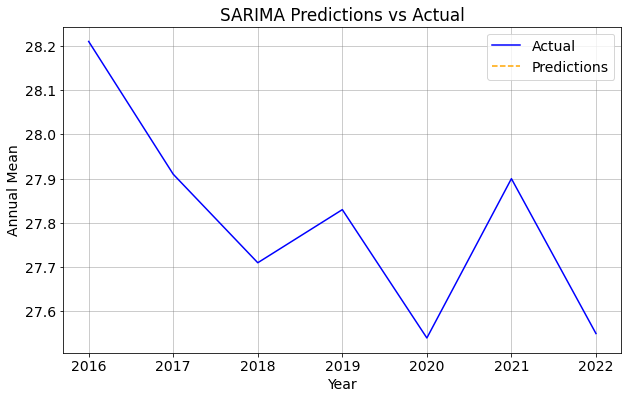

In [166]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Actual'], label='Actual', color='blue')
plt.plot(results.index, results['Predictions'], label='Predictions', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Annual Mean')
plt.title('SARIMA Predictions vs Actual')
plt.show()